# Predicting gender from names

## Table of Contents

##### I. <a href=#I>Preliminary steps</a>
##### II. <a href=#II>Prepare the data</a>
##### III. <a href=#III>Feed-forward neural network model</a>
##### IV. <a href=#IV>Long short-term memory model</a>
##### V. <a href=#V>Naive discriminative learning model</a>

## I. Preliminary steps <a ID="I"></a> 

### Import necessary libraries and set up the working directory

In [ ]:
### Import necessary packages
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import metrics
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import talos as ta
import warnings

### Set working directory
TOP = '/media/Deep_text_modelling_package_repo/'
WD = TOP + 'package'
os.chdir(WD)

### Import local packages
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes and matplotlib
pd.set_option('display.max_colwidth', 100) # Max width of columns when dispalying datasets
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
warnings.filterwarnings('ignore') # Hide warnings
warnings.simplefilter('ignore')
%matplotlib inline

### Define file paths

In [2]:
NAMES_FULL_CSV = TOP + "illustrative_examples/names/Data/Names_full.csv"
NAMES_TRAIN_CSV = TOP + "illustrative_examples/names/Data/Names_train.csv"
NAMES_VALID_CSV = TOP + "illustrative_examples/names/Data/Names_valid.csv"
NAMES_TEST_CSV = TOP + "illustrative_examples/names/Data/Names_test.csv"
CUE_INDEX = TOP + "illustrative_examples/names/Data/Cue_index.csv"
OUTCOME_INDEX = TOP + "illustrative_examples/names/Data/Outcome_index.csv"
TEMP_DIR = TOP + "illustrative_examples/names/Data/"

### Parameters to use

In [3]:
N_outcomes = 2  # number of most frequent outcomes to keep 
N_cues = 26  # number of cues to keep (all alphabet letters)
max_len = 11 # consider only the first 'max_len' cues in a sequence when applying LSTM (11 is the longest name in the dataset)
no_threads = 10 # Number of CPU threads to use
prop_valid = 1/10 # proportion of validation data
prop_test = 1/10 # proportion of test data

## II. Prepare the data <a name="II"></a> 

### Load the data

In [4]:
names_full = pd.read_csv(NAMES_FULL_CSV)
print(f'Number of examples: {len(names_full)}')
names_full.head(5)

Number of examples: 6782


,first_name,gender
0,John,m
1,William,m
2,James,m
3,Charles,m
4,George,m


### Prepare the cues and outcomes

In [5]:
# Create the unigraph cues
names_full['cues'] = names_full['first_name'].apply(lambda s: pr.orthoCoding(s, gram_size = 1))

# Rename the column gender as 'outcomes'
names_full.rename(columns={"gender": "outcomes"}, inplace = True)
names_full = names_full[['cues', 'outcomes']]
names_full.head(5)

,cues,outcomes
0,j_o_h_n,m
1,w_i_l_l_i_a_m,m
2,j_a_m_e_s,m
3,c_h_a_r_l_e_s,m
4,g_e_o_r_g_e,m


### Create index systems for the cues and outcomes

In [6]:
# Create the files containing the index systems
pr.create_index_systems_from_df(data = names_full, 
                                cue_index_path = CUE_INDEX, 
                                outcome_index_path = OUTCOME_INDEX)

In [7]:
# Import the cue index system
cue_to_index = pr.import_index_system(CUE_INDEX, N_tokens = N_cues)
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{e: 2}
{n: 3}
{i: 4}
{l: 5}


In [8]:
# Order dictionary alphabetically
cue_to_index = {k:(i+1) for i,k in enumerate(sorted(cue_to_index.keys()))}
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{b: 2}
{c: 3}
{d: 4}
{e: 5}


In [9]:
# Import the outcome index system
outcome_to_index = pr.import_index_system(OUTCOME_INDEX)
outcome_to_index

{'m': 1, 'f': 2}

In [10]:
# Reverse the cue dictionary
index_to_cue = pr.reverse_dictionary(cue_to_index)
# Reverse the outcome dictionary
index_to_outcome = pr.reverse_dictionary(outcome_to_index)
index_to_outcome

{1: 'm', 2: 'f'}

### Split into training, validation and test sets

In [11]:
# Create train, valid and test set files
pr.df_train_valid_test_split(data = names_full, 
                             train_data_path = NAMES_TRAIN_CSV, 
                             valid_data_path = NAMES_VALID_CSV, 
                             test_data_path = NAMES_TEST_CSV, 
                             p_valid = prop_valid, 
                             p_test = prop_test)

- Number of rows in the original set is 6782
- Number of rows in the training set is 5426
- Number of rows in the validation set is 678
- Number of rows in the test set is 678


In [12]:
# Load the train, valid and test sets
names_train = pd.read_csv(NAMES_TRAIN_CSV, sep=',', na_filter = False)
names_valid = pd.read_csv(NAMES_VALID_CSV, sep=',', na_filter = False)
names_test = pd.read_csv(NAMES_VALID_CSV, sep=',', na_filter = False)

## III. Feed-forward neural network model <a ID="III"></a> 

### Tokenisation

In [13]:
# Extract an event
event1 = names_train.iloc[[1]]
event1

,cues,outcomes
1,k_y_r_i_e,f


In [14]:
# cues
cues1 = names_train.loc[names_train.index[1], 'cues']
cues1_onehot_FNN = md.seq_to_onehot_1darray(cues1, index_system = cue_to_index, N_tokens = N_cues)
cues1_onehot_FNN

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0.])

In [15]:
# outcomes
outcomes1 = names_train.loc[names_train.index[1], 'outcomes']
outcomes1_onehot_FNN = md.seq_to_onehot_1darray(outcomes1, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes1_onehot_FNN

array([0., 1.])

### Build a simple FNN model

Build a simple FNN with two hidden layers having 64 units 

In [39]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': Adam, 
    'losses': binary_crossentropy, 
    'activation': relu, 
    'last_activation': 'sigmoid'}

# Model fitting
FNN_hist, FNN_model = md.train_FNN(data_train = names_train, 
                                  data_valid = names_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/10
 - 2s - loss: 0.6956 - acc: 0.5360 - val_loss: 0.6820 - val_acc: 0.5863
Epoch 2/10
 - 1s - loss: 0.6780 - acc: 0.5745 - val_loss: 0.6678 - val_acc: 0.6228
Epoch 3/10
 - 1s - loss: 0.6637 - acc: 0.6117 - val_loss: 0.6529 - val_acc: 0.6555
Epoch 4/10
 - 1s - loss: 0.6511 - acc: 0.6287 - val_loss: 0.6389 - val_acc: 0.6652
Epoch 5/10
 - 1s - loss: 0.6367 - acc: 0.6491 - val_loss: 0.6267 - val_acc: 0.6629
Epoch 6/10
 - 1s - loss: 0.6313 - acc: 0.6438 - val_loss: 0.6191 - val_acc: 0.6674
Epoch 7/10
 - 1s - loss: 0.6273 - acc: 0.6529 - val_loss: 0.6141 - val_acc: 0.6741
Epoch 8/10
 - 1s - loss: 0.6220 - acc: 0.6510 - val_loss: 0.6106 - val_acc: 0.6763
Epoch 9/10
 - 1s - loss: 0.6205 - acc: 0.6568 - val_loss: 0.6081 - val_acc: 0.6778
Epoch 10/10
 - 1s - loss: 0.6185 - acc: 0.6562 - val_loss: 0.6061 - val_acc: 0.6749


In [41]:
FNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                1728      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 130       
Total params: 6,018
Trainable params: 6,018
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [46]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'hidden_layers':[0, 1, 2], # number of hidden layers (x3)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, RMSprop], # (x2)
     'losses': [binary_crossentropy], # (x1)
     'activation':[relu, elu], # (x2)
     'last_activation': ['sigmoid'] # (x1)
     }
# => Total number of combinations: 5*6*3*4*7*5*2*1*2*1 = 50400

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_FNN_names.csv'
md.grid_search_FNN(data_train = names_train, 
                   data_valid = names_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index,
                   params = p,
                   prop_grid = 3e-4, 
                   tuning_output_file = TUNING_PATH)

Iteration 1 out of 15: {'epochs': 30, 'batch_size': 32, 'hidden_layers': 2, 'hidden_neuron': 32, 'lr': 0.01, 'dropout': 0.2, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'activation': <function relu at 0x7f41a81b6598>, 'last_activation': 'sigmoid'}

Iteration 2 out of 15: {'epochs': 1, 'batch_size': 256, 'hidden_layers': 1, 'hidden_neuron': 128, 'lr': 0.002, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'activation': <function relu at 0x7f41a81b6598>, 'last_activation': 'sigmoid'}

Iteration 3 out of 15: {'epochs': 20, 'batch_size': 16, 'hidden_layers': 1, 'hidden_neuron': 128, 'lr': 0.01, 'dropout': 0, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'activation': <function relu at 0x7f41a81b6598>, 'last_activation': 'sigmoid'}

Iteration 4 out of 15: {'epochs': 30, 'batch_size': 8, 'hidden_

Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

### Assessing the grid search using talos

In [47]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the number of parameter combinations that were processed
r.rounds()

224

In [77]:
# Display the dataframe containing the tuning results
r.data.head()

,epochs,batch_size,hidden_layers,hidden_neuron,lr,dropout,optimizer,losses,activation,last_activation,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,1,32,2,32,0.01,0.2,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f41a8211598>,<function relu at 0x7f41a81b6598>,sigmoid,0.636300,0.644323,0.645529,0.640533,0.642466,0.610601,0.676339,0.677607,0.672619,0.675040
1,2,32,2,32,0.01,0.2,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f41a8211598>,<function relu at 0x7f41a81b6598>,sigmoid,0.611882,0.672707,0.672861,0.672707,0.672672,0.601282,0.680804,0.679075,0.684524,0.681744
2,3,32,2,32,0.01,0.2,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f41a8211598>,<function relu at 0x7f41a81b6598>,sigmoid,0.600020,0.680381,0.681157,0.678994,0.679995,0.599137,0.660714,0.659091,0.665179,0.662088
3,4,32,2,32,0.01,0.2,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f41a8211598>,<function relu at 0x7f41a81b6598>,sigmoid,0.593111,0.682322,0.681680,0.683987,0.682789,0.597627,0.672619,0.672786,0.672619,0.672672
4,5,32,2,32,0.01,0.2,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f41a8211598>,<function relu at 0x7f41a81b6598>,sigmoid,0.587002,0.691568,0.691825,0.690828,0.691275,0.594336,0.684524,0.683306,0.687500,0.685371


In [49]:
r.data.columns

Index(['epochs', 'batch_size', 'hidden_layers', 'hidden_neuron', 'lr',
       'dropout', 'optimizer', 'losses', 'activation', 'last_activation',
       'loss', 'acc', 'precision', 'recall', 'f1score', 'val_loss', 'val_acc',
       'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [50]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.6971726190476191
- Highest validation f1-score: 0.7798473738287754


In [51]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

15

In [52]:
# get the best paramaters
r.data.iloc[15,]

epochs                                                           16
batch_size                                                       32
hidden_layers                                                     2
hidden_neuron                                                    32
lr                                                             0.01
dropout                                                         0.2
optimizer                           <class 'keras.optimizers.Adam'>
losses             <function binary_crossentropy at 0x7f41a8211598>
activation                        <function relu at 0x7f41a81b6598>
last_activation                                             sigmoid
loss                                                       0.549816
acc                                                        0.714035
precision                                                  0.714079
recall                                                     0.713942
f1score                                         

### Retraining with the best parameters

In [131]:
### Hyperparameters to use
p = {'epochs': 16, # number of iterations on the full set 
    'batch_size': 32, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':32, # number of neurons in the input layer 
    'lr': 0.01, # learning rate       
    'dropout': 0.2, 
    'optimizer': Adam, 
    'losses': binary_crossentropy, 
    'activation': relu, 
    'last_activation': 'sigmoid'}

# Model fitting
FNN_hist, FNN_model = md.train_FNN(data_train = names_train, 
                                  data_valid = names_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/16
 - 2s - loss: 0.6438 - acc: 0.6323 - val_loss: 0.6136 - val_acc: 0.6689
Epoch 2/16
 - 0s - loss: 0.6140 - acc: 0.6646 - val_loss: 0.6027 - val_acc: 0.6615
Epoch 3/16
 - 1s - loss: 0.6037 - acc: 0.6783 - val_loss: 0.6009 - val_acc: 0.6778
Epoch 4/16
 - 1s - loss: 0.5932 - acc: 0.6856 - val_loss: 0.6025 - val_acc: 0.6868
Epoch 5/16
 - 1s - loss: 0.5873 - acc: 0.6906 - val_loss: 0.5980 - val_acc: 0.6845
Epoch 6/16
 - 1s - loss: 0.5869 - acc: 0.6870 - val_loss: 0.5999 - val_acc: 0.6734
Epoch 7/16
 - 1s - loss: 0.5813 - acc: 0.6954 - val_loss: 0.6024 - val_acc: 0.6823
Epoch 8/16
 - 1s - loss: 0.5727 - acc: 0.6991 - val_loss: 0.6011 - val_acc: 0.6808
Epoch 9/16
 - 1s - loss: 0.5725 - acc: 0.7040 - val_loss: 0.5924 - val_acc: 0.6823
Epoch 10/16
 - 1s - loss: 0.5680 - acc: 0.7040 - val_loss: 0.6023 - val_acc: 0.6905
Epoch 11/16
 - 1s - loss: 0.5708 - acc: 0.7064 - val_loss: 0.5938 - val_acc: 0.6853
Epoch 12/16
 - 1s - loss: 0.5606 - acc: 0.7107 - val_loss: 0.5956 - val_acc: 0.6830
E

In [132]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/FNN_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/FNN_history_dict_names'
md.export_model(model = FNN_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = FNN_hist, path = HISTORY_PATH)
del FNN_model, FNN_hist  # deletes the existing model and history dictionary

In [133]:
# Load the model and training history
FNN_model = md.import_model(MODEL_PATH)
FNN_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [134]:
# Performance on the last epoch of the training set
print(f"- Training loss in the last epoch: {FNN_history_dict['loss'][-1]}")
print(f"- Training accuracy in the last epoch: {FNN_history_dict['acc'][-1]}")

# Performance on the last epoch of the validation set
print(f"- Validation loss in the last epoch: {FNN_history_dict['val_loss'][-1]}")
print(f"- Validation accuracy in the last epoch: {FNN_history_dict['val_acc'][-1]}")

- Training loss in the last epoch: 0.5503997808024728
- Training accuracy in the last epoch: 0.7126479289940828
- Validation loss in the last epoch: 0.5927978810809907
- Validation accuracy in the last epoch: 0.6875


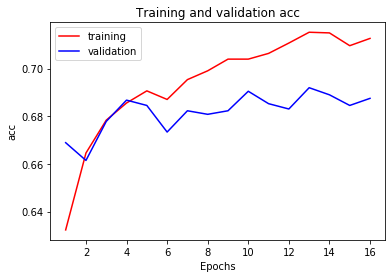

In [135]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = FNN_history_dict, metric = 'acc', set = 'train_valid')

In [136]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_FNN(model = FNN_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index)
outcome1_prob_pred

array([0.9523542 , 0.04773573], dtype=float32)

In [137]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_FNN(model = FNN_model, 
                                           data_test = names_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index)

In [138]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6858407079646017

In [139]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.67741935 0.69436202]


## IV. Long short-term memory model <a ID="IV"></a> 

### Tokenisation

In [72]:
# Extract an event
event1 = names_train.iloc[[1]]
event1

,cues,outcomes
1,k_y_r_i_e,f


In [73]:
# cues
cues1 = names_train.loc[names_train.index[1], 'cues']
cues1_onehot_LSTM = md.seq_to_onehot_2darray(cues1, index_system = cue_to_index, N_tokens = N_cues, max_len = max_len)
cues1_onehot_LSTM

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [74]:
# outcomes
outcomes1 = names_train.loc[names_train.index[1], 'outcomes']
outcomes1_onehot_LSTM = md.seq_to_onehot_1darray(outcomes1, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes1_onehot_LSTM

array([0., 1.])

### Build a simple LSTM model

Build a simple LSTM that has 64 hidden units 

In [75]:
### Build a simple LSTM that has 64 hidden units 
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_neuron': 64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': RMSprop, 
    'losses': binary_crossentropy, 
    'last_activation': 'sigmoid'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = names_train, 
                                     data_valid = names_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/10
 - 6s - loss: 0.6870 - acc: 0.6293 - val_loss: 0.6769 - val_acc: 0.6763
Epoch 2/10
 - 6s - loss: 0.6588 - acc: 0.6522 - val_loss: 0.6396 - val_acc: 0.6577
Epoch 3/10
 - 4s - loss: 0.6320 - acc: 0.6462 - val_loss: 0.6238 - val_acc: 0.6585
Epoch 4/10
 - 4s - loss: 0.6177 - acc: 0.6625 - val_loss: 0.6088 - val_acc: 0.6763
Epoch 5/10
 - 5s - loss: 0.6015 - acc: 0.6812 - val_loss: 0.5913 - val_acc: 0.6905
Epoch 6/10
 - 4s - loss: 0.5844 - acc: 0.7051 - val_loss: 0.5728 - val_acc: 0.7158
Epoch 7/10
 - 5s - loss: 0.5661 - acc: 0.7135 - val_loss: 0.5579 - val_acc: 0.7217
Epoch 8/10
 - 6s - loss: 0.5542 - acc: 0.7250 - val_loss: 0.5482 - val_acc: 0.7366
Epoch 9/10
 - 6s - loss: 0.5449 - acc: 0.7303 - val_loss: 0.5422 - val_acc: 0.7359
Epoch 10/10
 - 4s - loss: 0.5397 - acc: 0.7344 - val_loss: 0.5385 - val_acc: 0.7396


In [78]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                23296     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 23,426
Trainable params: 23,426
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [79]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, Nadam, RMSprop, SGD], # (x4)
     'losses': [binary_crossentropy], # (x1)
     'last_activation': ['sigmoid'] # (x1)
     }
# => Total number of combinations: 5*6*4*7*5*4*1*1 = 16800

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_LSTM_names.csv'
md.grid_search_LSTM(data_train = names_train, 
                    data_valid = names_valid, 
                    cue_index = cue_to_index, 
                    outcome_index = outcome_to_index,
                    max_len = max_len,
                    params = p,
                    prop_grid = 6e-4, 
                    tuning_output_file = TUNING_PATH)

Iteration 1 out of 10: {'epochs': 10, 'batch_size': 64, 'hidden_neuron': 32, 'lr': 0.0001, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'last_activation': 'sigmoid'}

Iteration 2 out of 10: {'epochs': 1, 'batch_size': 16, 'hidden_neuron': 64, 'lr': 0.0005, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Nadam'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'last_activation': 'sigmoid'}

Iteration 3 out of 10: {'epochs': 20, 'batch_size': 16, 'hidden_neuron': 16, 'lr': 0.0002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'last_activation': 'sigmoid'}

Iteration 4 out of 10: {'epochs': 10, 'batch_size': 64, 'hidden_neuron': 128, 'lr': 0.0005, 'dropout': 0.1, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function binary_crossentropy at 0x7f41a8211598>, 'last_activation': 'sigmoid'}

Iteration 5 out of 10

### Assessing the grid search using talos

In [80]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.8484375
- Highest validation f1-score: 0.9859538731120882


In [81]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

69

In [82]:
# get the best paramaters
r.data.iloc[69,]

epochs                                                           29
batch_size                                                       64
hidden_neuron                                                   128
lr                                                             0.01
dropout                                                         0.4
optimizer                        <class 'keras.optimizers.RMSprop'>
losses             <function binary_crossentropy at 0x7f41a8211598>
last_activation                                             sigmoid
loss                                                      0.0480704
acc                                                        0.985956
precision                                                  0.986046
recall                                                     0.985863
f1score                                                    0.985954
val_loss                                                   0.854036
val_acc                                         

### Retraining with the best parameters

In [140]:
### Hyperparameters to use
p = {'epochs': 29, # number of iterations on the full set 
    'batch_size': 64, 
    'hidden_neuron': 128, # number of neurons in the input layer 
    'lr': 0.01, # learning rate       
    'dropout': 0.4, 
    'optimizer': RMSprop, 
    'losses': binary_crossentropy, 
    'last_activation': 'sigmoid'}

# Model fitting
LSTM_hist, LSTM_model = md.train_LSTM(data_train = names_train, 
                                     data_valid = names_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     metrics = ['accuracy'],
                                     params = p)

In [141]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/LSTM_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/LSTM_history_dict_names'
md.export_model(model = LSTM_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = LSTM_hist, path = HISTORY_PATH)
del LSTM_model, LSTM_hist  # deletes the existing model and history dictionary

In [142]:
# Load the model and training history
LSTM_model = md.import_model(MODEL_PATH)
LSTM_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

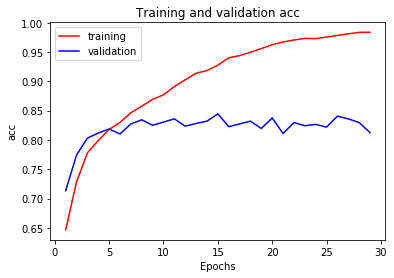

In [143]:
# Generate plots to assess the performance of the simple LSTM
ev.plot_learning_curve(history_dict = LSTM_history_dict, metric = 'acc', set = 'train_valid')

In [144]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_LSTM(model = LSTM_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index,
                                                   max_len = max_len)
outcome1_prob_pred

array([9.9998808e-01, 1.1609335e-05], dtype=float32)

In [145]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_LSTM(model = LSTM_model, 
                                           data_test = names_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           max_len = max_len)

In [146]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8156342182890856

In [147]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.83284457 0.79821958]


## V. Naive discriminative learning model <a ID="V"></a> 

### Build a simple NDL model

In [95]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = names_train, 
                                           data_valid = names_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = no_threads, 
                                           params = p)

Epoch 1/10
 - 14s - acc: 0.6461 - val_acc: 0.6519
Epoch 2/10
 - 15s - acc: 0.6535 - val_acc: 0.6637
Epoch 3/10
 - 14s - acc: 0.6590 - val_acc: 0.6622
Epoch 4/10
 - 14s - acc: 0.6629 - val_acc: 0.6637
Epoch 5/10
 - 14s - acc: 0.6638 - val_acc: 0.6681
Epoch 6/10
 - 14s - acc: 0.6629 - val_acc: 0.6740
Epoch 7/10
 - 14s - acc: 0.6635 - val_acc: 0.6770
Epoch 8/10
 - 14s - acc: 0.6648 - val_acc: 0.6711
Epoch 9/10
 - 14s - acc: 0.6659 - val_acc: 0.6681
Epoch 10/10
 - 14s - acc: 0.6668 - val_acc: 0.6637


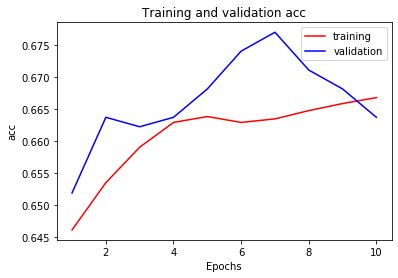

In [96]:
# Generate learning curve
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'acc', set = 'train_valid')

### Tune the parameters to find a good model

In [98]:
### Parameter tuning using grid search 
p = {'lr': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], # learning rate (x8)
     'epochs': [1, 2, 4, 6, 8], # number of iterations on the full set (x6)
     }
# => Total number of combinations: 8*5 = 40

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_NDL_names.csv'
md.grid_search_NDL(data_train = names_train, 
                   data_valid = names_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index, 
                   temp_dir = TEMP_DIR,
                   params = p, 
                   prop_grid = 0.1, 
                   tuning_output_file = TUNING_PATH, 
                   num_threads = no_threads)

Iteration 1 out of 4: {'lr': 5e-05, 'epochs': 2}

Iteration 2 out of 4: {'lr': 1e-05, 'epochs': 8}

Iteration 3 out of 4: {'lr': 0.001, 'epochs': 8}

Iteration 4 out of 4: {'lr': 0.001, 'epochs': 6}

This parameter combination has already been processed: {'lr': 0.001, 'epochs': 6}



### Assessing the grid search using talos

In [99]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.6769911504424779
- Highest validation f1-score: 0.6645842460087221


In [100]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

16

In [101]:
# get the best paramaters
r.data.iloc[16,]

lr               0.001000
epochs           7.000000
acc              0.663472
precision        0.663357
recall           0.663288
f1score          0.663307
val_acc          0.676991
val_precision    0.677208
val_recall       0.676867
val_f1score      0.676788
Name: 16, dtype: float64

### Retraining with the best parameters

In [102]:
### Hyperparameters to use
p = {'epochs': 7, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = names_train, 
                                           data_valid = names_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = no_threads, 
                                           verbose = 1,
                                           params = p)

Epoch 1/7
 - 16s - acc: 0.6461 - val_acc: 0.6519
Epoch 2/7
 - 16s - acc: 0.6535 - val_acc: 0.6637
Epoch 3/7
 - 15s - acc: 0.6590 - val_acc: 0.6622
Epoch 4/7
 - 14s - acc: 0.6629 - val_acc: 0.6637
Epoch 5/7
 - 14s - acc: 0.6638 - val_acc: 0.6681
Epoch 6/7
 - 14s - acc: 0.6629 - val_acc: 0.6740
Epoch 7/7
 - 14s - acc: 0.6635 - val_acc: 0.6770


In [103]:
# Save the weights and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/NDL_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/NDL_history_dict_names'
md.export_model(model = NDL_model, path = MODEL_PATH)  # create a HDF5 file 
md.export_history(history_dict = NDL_history_dict, path = HISTORY_PATH)
del NDL_model, NDL_history_dict  # delete the existing model and history dictionary

In [111]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/NDL_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/NDL_history_dict_names'
NDL_model = md.import_model(MODEL_PATH)
NDL_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [105]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq)
outcome1_prob_pred

array([0.68082355, 0.31917645])

In [112]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_NDL(model = NDL_model, 
                                           data_test = names_test, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = no_threads)

In [113]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6710914454277286

In [114]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.64516129 0.69732938]
